In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
import scipy as sci
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


## variable params

In [2]:
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
ae_run_n = 113
#qr_run_n, qr_model_str, train_share = 8, 'dense_70pct_train', 0.7
#qr_run_n, qr_model_str, train_share = 9, 'dense_50pct_train', 0.5
#qr_run_n, qr_model_str, train_share = 7, 'dense_polyfit', 0.2
#qr_run_n, qr_model_str, train_share = 31, 'dense_kfold', 0
#qr_run_n, qr_model_str, train_share = 32, 'dense_kfold_polyfit5', 0
#qr_run_n, qr_model_str, train_share = 33, 'dense_kfold_lmfit5', 0
#qr_run_n, qr_model_str, train_share = 34, 'dense_kfold_lmfit11', 0
#qr_run_n, qr_model_str, train_share = 35, 'dense_kfold_curvefit11', 0
qr_run_n, qr_model_str, train_share = 46, 'dense_kfold_lmfit11_expobin', 0


#quantiles = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quantiles = [0.0, 0.3, 0.5, 0.7, 0.9]

In [3]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
quant_tmplt_idx = 0
quant_tmplt = quantiles[quant_tmplt_idx]

In [4]:
paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

## fixed params

In [5]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [6]:
# efficiencies
quantiles_tmp = np.asarray(quantiles+[1.])
effs = (quantiles_tmp)[quant_tmplt_idx+1:] - (quantiles_tmp)[quant_tmplt_idx:-1]
effs = effs[1:]/effs[0] # efficiency-test-quantiles/efficiency-template-quantile

In [7]:
effs

array([0.66666667, 0.66666667, 0.66666667, 0.33333333])

In [8]:
n_bins = 100
min_mjj = 1200.
max_mjj = 5600.
expo_binning = True
dijet_binning = False


if dijet_binning:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
elif expo_binning:
    x_shift = 3
    lin_bins = np.linspace(0.,1.,n_bins)
    exp_bins = lin_bins/(np.exp(-lin_bins+x_shift)/np.exp(x_shift-1))
    bin_edges = exp_bins*(max_mjj-min_mjj)+min_mjj
    
else: # simple linear binning
    bin_edges = np.array(np.linspace(min_mjj, max_mjj, n_bins).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
    
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

## data reading

In [9]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

    for sample_id in sample_ids:
        samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [10]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[quant_tmplt_idx:], quantiles[quant_tmplt_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[quant_tmplt_idx:], quantiles[quant_tmplt_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[quant_tmplt_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

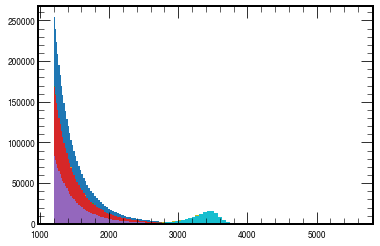

In [11]:
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths)

# 2-sample test with poisson likelihood

In [12]:
np.set_printoptions(precision=3, suppress=False)

In [13]:
def poisson_log_likelihood(observed, expected): # bin_h_exp must be already scaled to efficiency
    like = sci.stats.poisson.pmf(k=observed.astype('int'), mu=expected.astype('int'))
    return np.sum(-np.log(like), axis=-1) # calculating negative log like (the smaller p, the larger -log like => test for right tail)

In [14]:
def p_value_from_toys(toy_likelihoods, obs_likelihood):
    return sum(toy_likelihoods > obs_likelihood)/float(len(toy_likelihoods))

In [15]:
likelihoods_per_quantile = {}
expected_per_xsec = hist_data[quant_tmplt]

for quant_test, eff in zip(quantiles[quant_tmplt_idx+1:], effs):
    
    likelihoods_per_xsec = {}
    observed_per_xsec = hist_data[quant_test]
    
    for xsec in xsecs_sig:
        observed = observed_per_xsec[xsec]
        expected = expected_per_xsec[xsec]*eff
        likelihood = poisson_log_likelihood(observed, expected)
        likelihoods_per_xsec[xsec] = likelihood
        print('quant {}, xsec {}: likelihood {}'.format(quant_test,xsec,likelihood))
    
    likelihoods_per_quantile[quant_test] = likelihoods_per_xsec

quant 0.3, xsec 0: likelihood 569.5119842558292
quant 0.3, xsec 20: likelihood 570.2398582376662
quant 0.3, xsec 40: likelihood 571.208563416371
quant 0.3, xsec 60: likelihood 572.8273381203487
quant 0.3, xsec 80: likelihood 574.2157737186357
quant 0.3, xsec 100: likelihood 575.0181507665903
quant 0.5, xsec 0: likelihood 573.8016778479462
quant 0.5, xsec 20: likelihood 572.7140034351027
quant 0.5, xsec 40: likelihood 573.8662369304992
quant 0.5, xsec 60: likelihood 575.9280341492956
quant 0.5, xsec 80: likelihood 577.765429112078
quant 0.5, xsec 100: likelihood 581.1895609392834
quant 0.7, xsec 0: likelihood 562.2201707069958
quant 0.7, xsec 20: likelihood 564.9616757907929
quant 0.7, xsec 40: likelihood 572.475342832784
quant 0.7, xsec 60: likelihood 584.6238225876614
quant 0.7, xsec 80: likelihood 600.2456344889283
quant 0.7, xsec 100: likelihood 620.2622030845282
quant 0.9, xsec 0: likelihood 536.2167455173394
quant 0.9, xsec 20: likelihood 537.635643120733
quant 0.9, xsec 40: likel

### compute toys for null-test-statistic distribution

In [16]:
toy_n = int(1e5)
toy_likes_per_xsec = {}
for xsec in xsecs_sig:
    # take expected bin heights as mu
    expected = expected_per_xsec[xsec]
    toy = sci.stats.poisson.rvs(expected, size=(toy_n,len(expected)))
    toy_likes = poisson_log_likelihood(toy, expected)
    toy_likes_per_xsec[xsec] = toy_likes

## compute and plot p-value under toy null distribution

quantile 0.3 pvalue
[3e-05, 0.0, 1e-05, 0.0, 0.0, 0.0]
quantile 0.5 pvalue
[1e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
quantile 0.7 pvalue
[0.00052, 0.00025, 0.0, 0.0, 0.0, 0.0]
quantile 0.9 pvalue
[0.51445, 0.43715, 0.00973, 0.0, 0.0, 0.0]


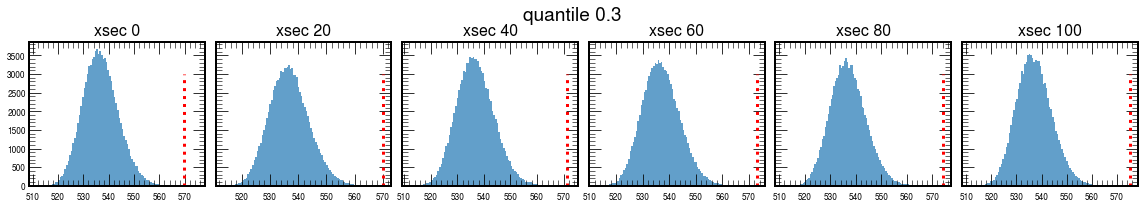

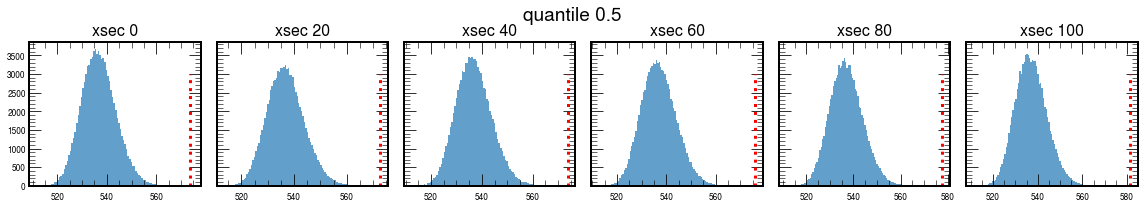

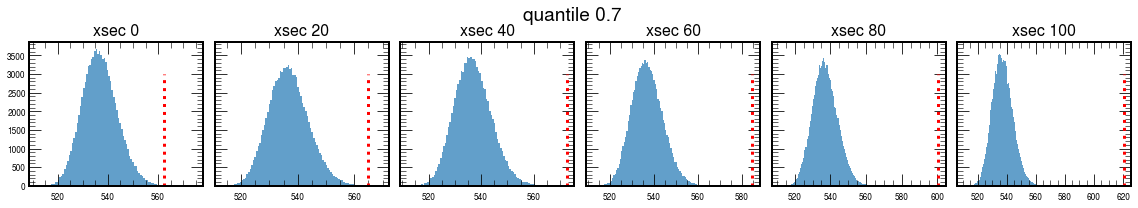

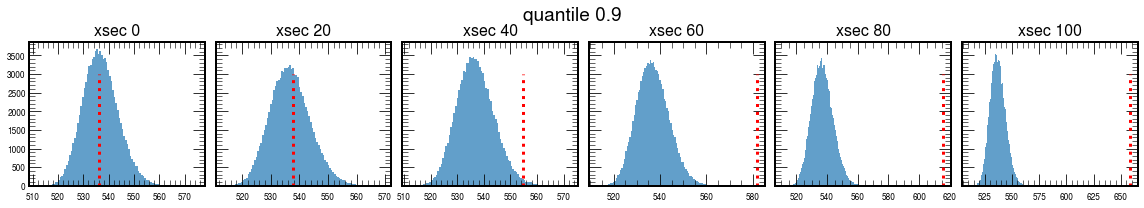

In [17]:
pvals_per_quant = {}
for quantile, obs_likelihoods_per_xsec in likelihoods_per_quantile.items():
    fig, axs = plt.subplots(1,len(xsecs_sig),sharey=True,figsize=(16,3))
    pvals = []
    for xsec, ax in zip(xsecs_sig, axs.flat):
        toy_likes = toy_likes_per_xsec[xsec]
        obs_like = obs_likelihoods_per_xsec[xsec]
        pval = p_value_from_toys(toy_likes, obs_like)
        pvals.append(pval)
        _ = ax.hist(toy_likes, bins=100, alpha=0.7)
        ax.vlines(obs_like, color='r', ymin=0, ymax=3e3, ls=':',lw=3)
        ax.set_title('xsec {}'.format(xsec), fontsize=16)
    fig.suptitle('quantile {}'.format(quantile), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    print('quantile {} pvalue'.format(quantile))
    print(pvals)
    pvals_per_quant[quantile] = pvals

Text(0.5, 1.0, 'dense_kfold_lmfit11_expobin model, 0.0-0.3 template quantile')

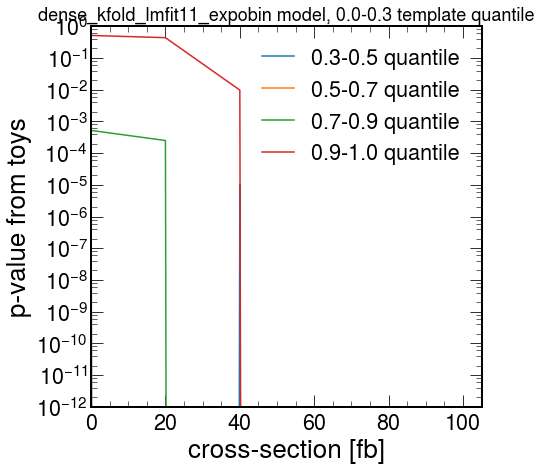

In [18]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, c in zip(quantiles[quant_tmplt_idx+1:], palette):
            
    label = '{}-{} quantile'.format((quantiles+['1.0'])[quantiles.index(quant)], (quantiles+['1.0'])[quantiles.index(quant)+1])
    plt.semilogy(xsecs_sig, pvals_per_quant[quant], color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('p-value from toys')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quantiles[quant_tmplt_idx],quantiles[quant_tmplt_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants_inv[template_q_idx+1],quants_inv[template_q_idx], (quants_inv+['0.0'])[quants.index(quant)+1], (quants_inv+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

In [19]:
sci.stats.poisson.pmf(k=10,mu=20)

0.00581630651834512

In [26]:
sci.stats.poisson.pmf(k=50,mu=100)

0.00589403768537651

In [27]:
(20-10)/20

0.5

In [28]:
(200-175)/200

0.125

In [31]:
sci.stats.poisson.pmf(k=20,mu=20)

0.0888353173920848

In [32]:
sci.stats.poisson.pmf(k=1750,mu=2000)

7.79214626347325e-10

In [94]:
x = np.linspace(0,200,500)

In [92]:
x

array([  0.   ,   0.301,   0.601,   0.902,   1.202,   1.503,   1.804,
         2.104,   2.405,   2.705,   3.006,   3.307,   3.607,   3.908,
         4.208,   4.509,   4.81 ,   5.11 ,   5.411,   5.711,   6.012,
         6.313,   6.613,   6.914,   7.214,   7.515,   7.816,   8.116,
         8.417,   8.717,   9.018,   9.319,   9.619,   9.92 ,  10.22 ,
        10.521,  10.822,  11.122,  11.423,  11.723,  12.024,  12.325,
        12.625,  12.926,  13.226,  13.527,  13.828,  14.128,  14.429,
        14.729,  15.03 ,  15.331,  15.631,  15.932,  16.232,  16.533,
        16.834,  17.134,  17.435,  17.735,  18.036,  18.337,  18.637,
        18.938,  19.238,  19.539,  19.84 ,  20.14 ,  20.441,  20.741,
        21.042,  21.343,  21.643,  21.944,  22.244,  22.545,  22.846,
        23.146,  23.447,  23.747,  24.048,  24.349,  24.649,  24.95 ,
        25.251,  25.551,  25.852,  26.152,  26.453,  26.754,  27.054,
        27.355,  27.655,  27.956,  28.257,  28.557,  28.858,  29.158,
        29.459,  29.

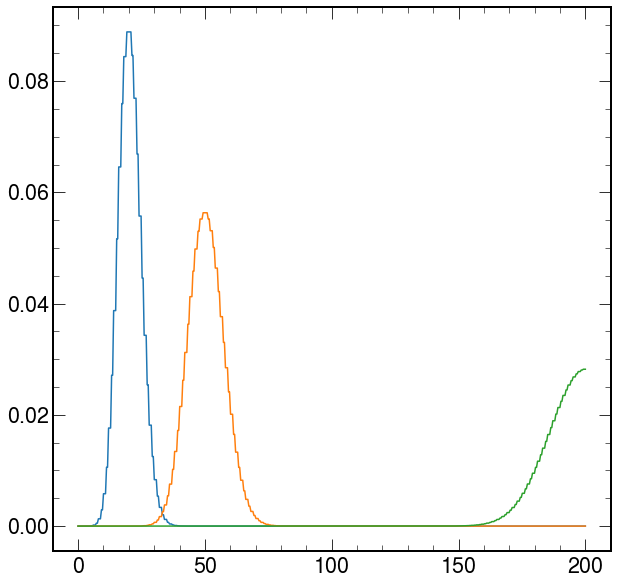

In [95]:
plt.plot(x,sci.stats.poisson.pmf(k=x.astype('int'),mu=20))
plt.plot(x,sci.stats.poisson.pmf(k=x.astype('int'),mu=50))
plt.plot(x,sci.stats.poisson.pmf(k=x.astype('int'),mu=200))

In [38]:
sci.stats.poisson.pmf(k=x.astype('int'),mu=50)

array([1.929e-22, 9.644e-21, 2.411e-19, 4.018e-18, 5.023e-17, 5.023e-16,
       4.186e-15, 2.990e-14, 1.869e-13, 1.038e-12, 5.191e-12, 2.359e-11,
       9.831e-11, 3.781e-10, 1.350e-09, 4.501e-09, 1.407e-08, 4.137e-08,
       1.149e-07, 3.024e-07, 7.561e-07, 1.800e-06, 4.091e-06, 8.894e-06,
       1.853e-05, 3.706e-05, 7.127e-05, 1.320e-04, 2.357e-04, 4.063e-04,
       6.772e-04, 1.092e-03, 1.707e-03, 2.586e-03, 3.803e-03, 5.432e-03,
       7.545e-03, 1.020e-02, 1.342e-02, 1.720e-02, 2.150e-02, 2.622e-02,
       3.121e-02, 3.629e-02, 4.124e-02, 4.583e-02, 4.981e-02, 5.299e-02,
       5.520e-02, 5.633e-02, 5.633e-02, 5.522e-02, 5.310e-02, 5.009e-02,
       4.638e-02, 4.216e-02, 3.765e-02, 3.302e-02, 2.847e-02, 2.413e-02,
       2.010e-02, 1.648e-02, 1.329e-02, 1.055e-02, 8.240e-03, 6.339e-03,
       4.802e-03, 3.584e-03, 2.635e-03, 1.909e-03, 1.364e-03, 9.605e-04,
       6.670e-04, 4.568e-04, 3.087e-04, 2.058e-04, 1.354e-04, 8.791e-05,
       5.635e-05, 3.567e-05, 2.229e-05, 1.376e-05, 

In [70]:
x1 = np.arange(0, 20, 0.1)
y = sci.stats.poisson.pmf(x1, mu=10)

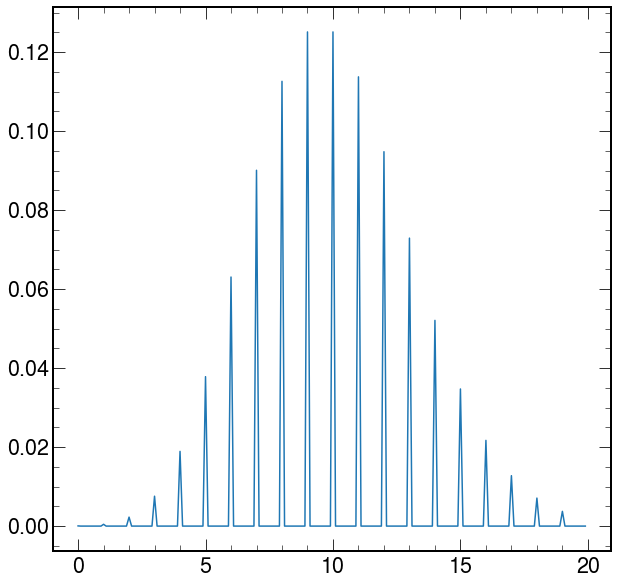

In [71]:
plt.plot(x1,y)

In [72]:
x1

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [81]:
x2 = np.arange(0,10,0.1)
y = sci.stats.poisson.pmf(x2, mu=5)

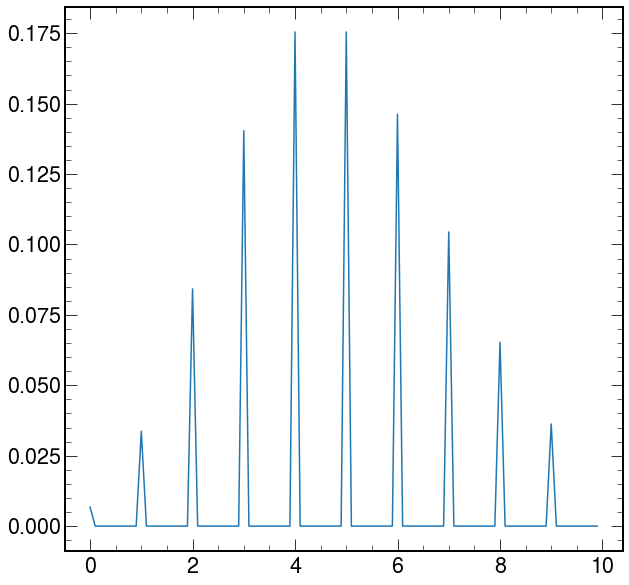

In [82]:
plt.plot(x2,y)

In [75]:
x2

array([ 0.   ,  0.101,  0.201,  0.302,  0.402,  0.503,  0.603,  0.704,
        0.804,  0.905,  1.005,  1.106,  1.206,  1.307,  1.407,  1.508,
        1.608,  1.709,  1.809,  1.91 ,  2.01 ,  2.111,  2.211,  2.312,
        2.412,  2.513,  2.613,  2.714,  2.814,  2.915,  3.015,  3.116,
        3.216,  3.317,  3.417,  3.518,  3.618,  3.719,  3.819,  3.92 ,
        4.02 ,  4.121,  4.221,  4.322,  4.422,  4.523,  4.623,  4.724,
        4.824,  4.925,  5.025,  5.126,  5.226,  5.327,  5.427,  5.528,
        5.628,  5.729,  5.829,  5.93 ,  6.03 ,  6.131,  6.231,  6.332,
        6.432,  6.533,  6.633,  6.734,  6.834,  6.935,  7.035,  7.136,
        7.236,  7.337,  7.437,  7.538,  7.638,  7.739,  7.839,  7.94 ,
        8.04 ,  8.141,  8.241,  8.342,  8.442,  8.543,  8.643,  8.744,
        8.844,  8.945,  9.045,  9.146,  9.246,  9.347,  9.447,  9.548,
        9.648,  9.749,  9.849,  9.95 , 10.05 , 10.151, 10.251, 10.352,
       10.452, 10.553, 10.653, 10.754, 10.854, 10.955, 11.055, 11.156,
      

In [76]:
x1

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15